In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as alea
%matplotlib inline
from decimal import Decimal

In [2]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

In [3]:
tau = 0.013 # time constant
dt = 0.002 # timestep
n = 2 # number of coordinates 
k = 0.01 # defined by the noise k*|u|²
n_try = 16 # number of repetitions
t_fix = .2 # fixation time
delay = .1 # delay
t_mov = .5 # movement time
T_mov = int(t_mov/dt) # index - duration of the mouvement
T_fix = int(t_fix/dt) # index - duration of the fixation
T_delay = int(delay/dt)# index - duration of the delay
T_tot = T_mov+T_fix+T_delay # index - total duration

def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt/tau
B[n-1] = dt

def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    """
    renvoie les n premières puissances de A dans un tableau où A est une matrice carrée
        
    """
    A_pow_array = np.zeros((T_mov+1,n,n))

    for i in np.arange(T_mov+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A) # crée le tableau pour le A défini plus haut

def pow_fast(n):
    """
    renvoie A puissance n où A est la matrice définie plus haut
        
    """
    return A_pow_array[n]

ci0_array = np.zeros(T_mov+1)

for i in np.arange(T_mov+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0] # calcul de la première composante du vecteur A^i*B 

ci1_array = np.zeros(T_mov+1)

for i in np.arange(T_mov+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1] # calcul de la deuxième composante du vecteur A^i*B 
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2] # calcul de la troisième composante du vecteur A^i*B 
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3] # calcul de la quatrième composante du vecteur A^i*B 

ci = np.array([ci0_array, ci1_array])#, ci2_array]) ; création d'une matrice à deux colonnes (plus rapide pour les calculs)


timee = np.linspace(-t_fix, delay+t_mov, T_tot+1) # temps (en s) discrétisé
time_ms = timee*1000 # temps (en ms) discrétisé


counter_right = np.zeros(n_try) # counter_right[i] = 1 si pour l'essai n°i la cible est allée à droite, sinon 0
counter_left = np.zeros(n_try) # counter_left[i] = 1 si pour l'essai n°i la cible est allée à gauche, sinon 0
window = 15 # largeur de la "fenêtre-mémoire", on considère que le sujet virtuel se souvient des window derniers essais en vue d'une anticipation
proba = 1 # probabilité que la cible aille à droite
distribution = (2*(alea.binomial(1, proba, n_try)-0.5)).astype(int) # binomial(1,p,n_try) : random selection of 1  with probability p and 0 with probability 1-p
ratio_anticipatory = .5 # lorsque la direction de la cible est connue, le sujet anticipe au mieux à 50% (ie à l'instant où le sujet reçoit l'information visuelle, il est à 50% de la vitesse de la cible ; exemple : au bout de 100ms le sujet est à 5 deg/s alors que la cible est à 10 deg/s)

n_iter = 5000 # nombre d'itérations dans la descente de gradient
eta = 5000 # pas de la descente de gradient

u_rec = np.zeros((n_try, T_tot+1)) # pour sauvegarder les valeurs du signal à chaque essai
pos_rec = np.zeros((n_try, T_tot+1)) # pour sauvegarder les valeurs de la position à chaque essai
vel_rec = np.zeros((n_try, T_tot+1)) # pour sauvegarder les valeurs de la vitesse à chaque essai

v = 10 # vitesse de la cible
xT = 0 # position à laquelle apparait la cible à t=0
v_anticipatory_max = ratio_anticipatory*v # vitesse maximale d'anticipation

import time
debut = time.time()

for i in np.arange(n_try):
    
    # calcul de la vitesse d'anticipation pendant la période d'anticipation
    if i < window:
        v_anticipation = np.linspace(0,v_anticipatory_max,T_delay)*((counter_right-counter_left)/window).sum()
    else:
        v_anticipation = np.linspace(0,v_anticipatory_max,T_delay)*((counter_right[(i-window):i]-counter_left[(i-window):i])/window).sum()
    
    # calcul du signal pendant la période d'anticipation
    u_rec[i, T_fix:(T_delay+T_fix)] = 1/tau*v_anticipation
    
    # calcul de la position pendant la période d'anticipation
    pos_rec[i, T_fix:(T_delay+T_fix)] = v_anticipation*timee[T_fix:(T_delay+T_fix)]
    
    vel_rec[i, T_fix:(T_delay+T_fix)] = v_anticipation

    # on détermine la direction, si distribution[0] négatif alors la cible part à gauche, sinon c'est à droite
    if distribution[i] < 0:
        counter_left[i] = 1
    else:
        counter_right[i] = 1
    
    # calcul du vecteur (position, vitesse) de l'oeil à la fin du délai (juste avant que l'information visuelle arrive)
    x0 = np.array([pos_rec[i,T_fix+T_delay-1], vel_rec[i,T_fix+T_delay-1]])
    
    # calcul du vecteur (position, vitesse) de la cible à la fin du délai (juste avant que l'information visuelle arrive)
    target = np.array([v*distribution[i]*delay + xT, v*distribution[i]])
    
    t_Tv = 0.02468+0.001739*np.abs(target[0]-x0[0]) # see Transitioning from Saccade to SPEM using LQTC, Korentis & Enderle ; valeur à modifier après étude empirique (notamment, il est ici réglé sur la position et pourrait être fait pour la vitesse pour le cas ASPEM)
    t_T =  float(round(Decimal(t_Tv),3)) # acceleration duration
    t_R =  t_mov-float(round(Decimal(t_Tv),3)) # fixing / pursuit duration
    T = int(np.round(t_T/dt)) # index - duration of the acceleration
    R = int(np.round(t_R/dt)) # index - duration of the fixation (on the moving target)
    
    def xT_f(t):
        """Computation of the target (position, velocity) vector at time t
        """
        return np.array([target[0]+target[1]*t*dt, target[1]])
    
    def expectation(u, t):
        """Computation of the expectation of the state vector at time t, given u
        """
        if t == 0:
            return x0
        else:
            return pow_fast(t).dot(x0)+(ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

    mult_v = np.array([1, 1]) # paramètre multiplicatif de la position et la vitesse ; pour diminuer l'influence de la position / augmenter l'influence de la vitesse, on met par ex : (0.01, 1) (plutot que (1,100))
    
    def variance(u, t):
        """Computation of the variance of the state vector at time t, given u
        """
        return k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()
    
    def cost_deriv(u, ii):
        """Derivative of the cost function with respect to u_i
        """
        if ii < T:
            return (2*np.transpose(ci[:,(T-ii-1):(T+R-ii)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (T+np.arange(R+1))])).sum() + 2*k*u[ii]*(ci0_array[(T+1-ii-1):(T+R-ii)]**2).sum()
        else:
            return (2*np.transpose(ci[:,0:(T+R-ii)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (ii+1+np.arange(R+T-ii))])).sum() + 2*k*u[ii]*(ci0_array[0:(T+R-ii)]**2).sum()

    ubang = np.zeros(T+R+1) # initialisation du signal
    
    # algorithme de la descente de gradient
    u = ubang.copy()
    for i_iter in np.arange(n_iter):
        u_old = u.copy()
        u[0:T+R] = u_old[0:T+R] - eta*np.array([cost_deriv(u_old, i) for i in np.arange(T+R)])
        
    u_rec[i, (T_tot-T_mov):(T_tot+1)] = u # on enregistre le signal
    
    position = np.zeros(T+R+1)
    velocity = np.zeros(T+R+1)
    
    
    # calcul de la position et la vitesse
    for j in np.arange(T+R+1):
        mean = expectation(u, j)
        position[j] = mean[0]
        velocity[j] = mean[1]
        
    pos_rec[i, (T_tot-T_mov):(T_tot+1)] = position # on enregistre la position
    vel_rec[i, (T_tot-T_mov):(T_tot+1)] = velocity # on enregistre la vitesse
    
fin = time.time()


In [16]:
(fin-debut)/60/60*20

15.575943210389877

In [156]:
cible = np.linspace(v*175*dt,v*275*dt,101)
pos_rec[48,200:301]-cible

array([-0.23333333, -0.23466667, -0.23356429, -0.23027727, -0.22504266,
       -0.21808504, -0.20961794, -0.19984521, -0.18896235, -0.17715771,
       -0.16461376, -0.15150822, -0.13801522, -0.12430637, -0.11055195,
       -0.09692192, -0.08358702, -0.07071992, -0.05849626, -0.04709581,
       -0.03670363, -0.02751123, -0.01971782, -0.01353157, -0.00917095,
       -0.00686615, -0.00686052, -0.00686043, -0.0068599 , -0.00685941,
       -0.00685892, -0.00685844, -0.00685797, -0.0068575 , -0.00685704,
       -0.00685659, -0.00685615, -0.00685571, -0.00685528, -0.00685485,
       -0.00685443, -0.00685402, -0.00685362, -0.00685322, -0.00685283,
       -0.00685245, -0.00685207, -0.0068517 , -0.00685134, -0.00685098,
       -0.00685063, -0.00685029, -0.00684996, -0.00684963, -0.00684931,
       -0.00684899, -0.00684868, -0.00684838, -0.00684809, -0.0068478 ,
       -0.00684752, -0.00684724, -0.00684698, -0.00684672, -0.00684646,
       -0.00684622, -0.00684598, -0.00684575, -0.00684552, -0.00

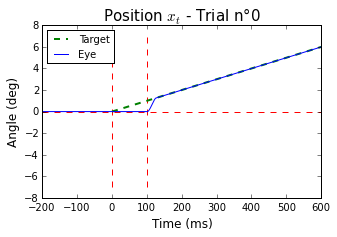

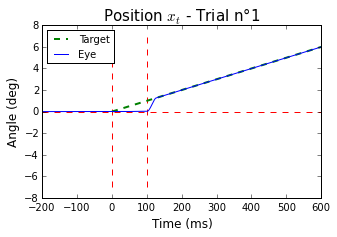

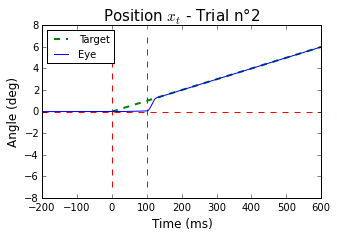

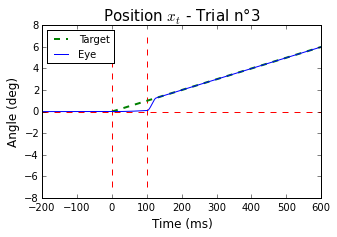

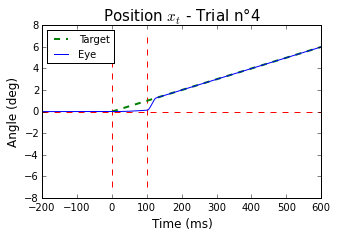

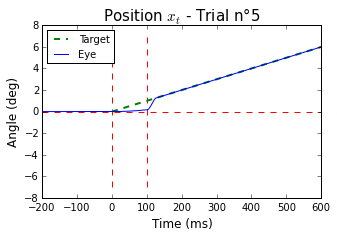

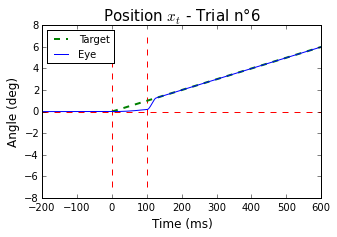

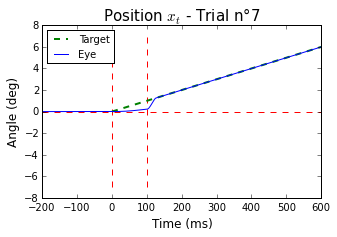

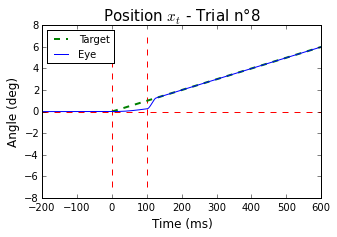

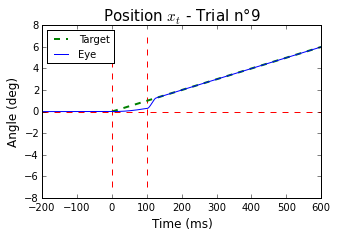

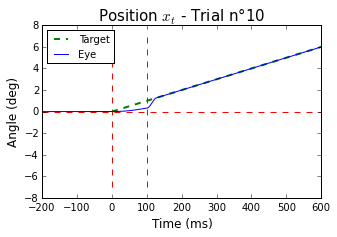

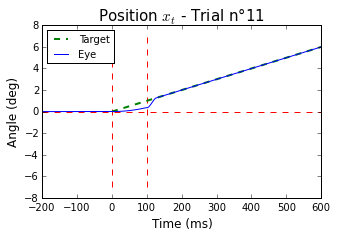

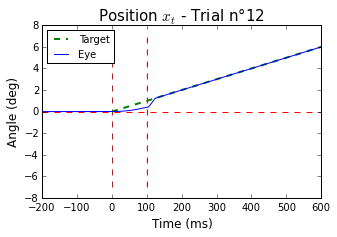

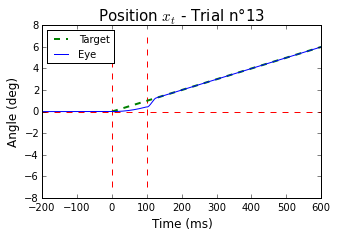

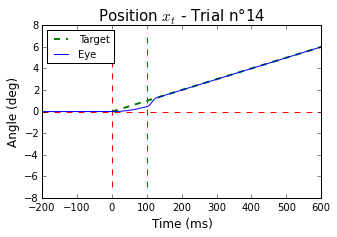

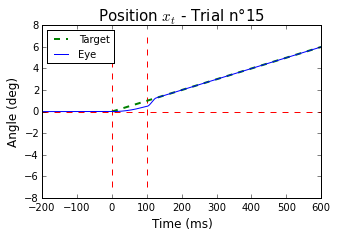

In [4]:
for i in np.arange(n_try):
    fig_width = 5
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
    plt.plot([-T_fix*dt*1000,(T_delay+T_mov)*dt*1000],[0,0],'r--')
    plt.plot([0,0],[-7,7],'r--')
    plt.plot([dt*1000*T_delay,dt*1000*T_delay],[-7,7],'r--')
    if distribution[i] > 0:
        plt.plot([0,dt*1000*(T_delay+T_mov)],[0,v*(delay+t_T+t_R)],color='g', lw=2, ls ='--', label="Target")
    else:
        plt.plot([0,dt*1000*(T_delay+T_mov)],[0,-v*(delay+t_T+t_R)],color='g', lw=2, ls ='--', label="Target")
    plt.plot(time_ms, pos_rec[i, :], lw=1, label="Eye")
    ax.set_title(r'Position $x_t$ - Trial n°'+str(i), fontsize = 15)
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Angle (deg)', fontsize=12)
    ax.set_xlim(-T_fix*dt*1000,(T_delay+T_mov)*dt*1000)
    ax.legend(loc='upper left',prop={'size':10})

    plt.show()

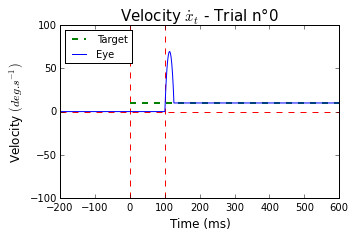

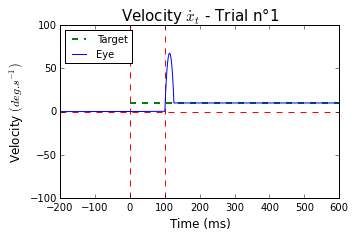

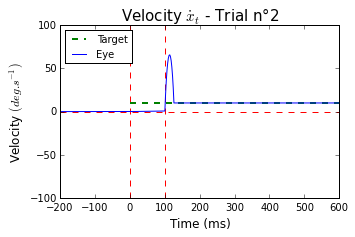

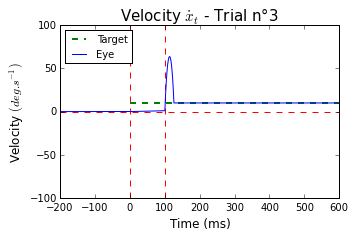

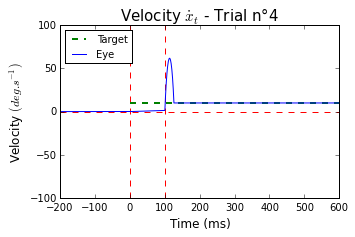

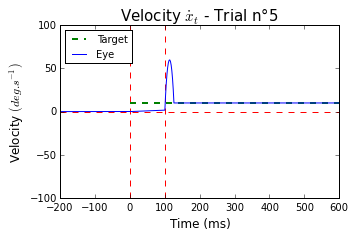

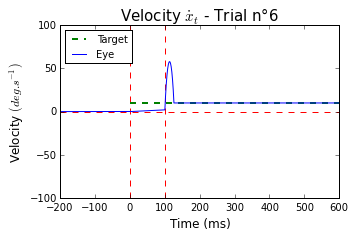

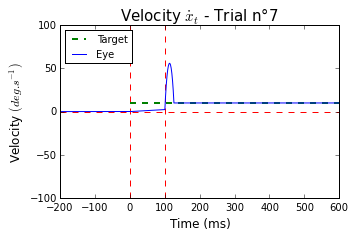

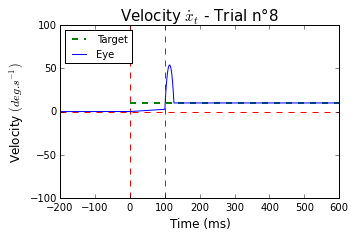

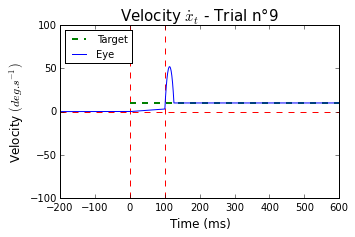

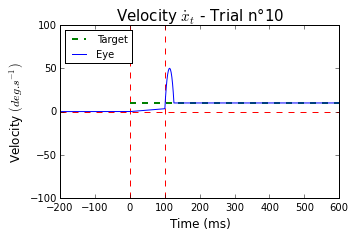

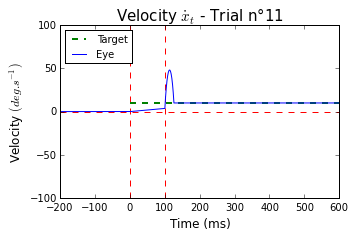

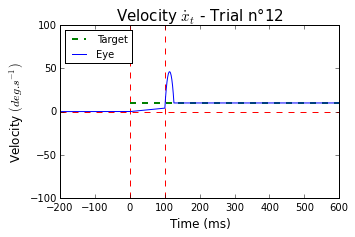

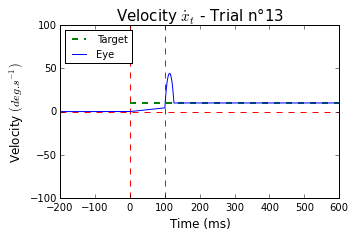

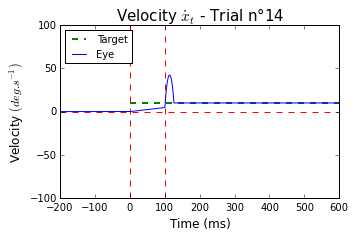

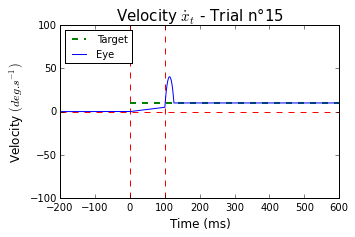

In [5]:
for i in np.arange(n_try):
    fig_width = 5
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
    plt.plot([-T_fix*dt*1000,(T_delay+T_mov)*dt*1000],[0,0],'r--')
    plt.plot([0,0],[-100,100],'r--')
    plt.plot([dt*1000*T_delay,dt*1000*T_delay],[-100,100],'r--')
    if distribution[i] > 0:
        plt.plot([0,dt*1000*(T_delay+T_mov)],[v,v],color='g', lw=2, ls ='--', label="Target")
    else:
        plt.plot([0,dt*1000*(T_delay+T_mov)],[-v,-v],color='g', lw=2, ls ='--', label="Target")
    plt.plot(time_ms, vel_rec[i, :], lw=1, label="Eye")
    ax.set_title(r'Velocity $\dot x_t$ - Trial n°'+str(i), fontsize = 15)
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Velocity $(deg.s^{-1})$', fontsize=12)
    ax.set_xlim(-T_fix*dt*1000,(T_delay+T_mov)*dt*1000)
    ax.legend(loc='upper left',prop={'size':10})

    plt.show()

In [177]:
import pickle
import pandas as pd
record = pd.DataFrame()
for i in np.arange(n_try):
    record_one = pd.DataFrame([{'position':pos_rec[i,:],'velocity':vel_rec[i,:]}],index=[i])
    record = pd.concat([record, record_one])
record.to_pickle('../2017_OptimalPrecision/DataRecording/ASPEM_n_try=75_p=0.8.pkl')

In [175]:
import pickle
import pandas as pd
record = pd.read_pickle('/home/baptiste/Documents/2017_OptimalPrecision/DataRecording/ASPEM_n_try=40_p=0.8.pkl')